<a target="_blank" href="https://colab.research.google.com/github/evaalonsoortiz/ELE8812-demos/blob/main/Demos/Lesson%203/Le%C3%A7on_3_Demo_replie1D.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# ELE8812 - Représentation fréquentielle

## Démo : Démonstration du phénomène de repliement, cadre 1D

Il est possible de reconstruire un signal à partir de la transformée de Fourier (TF) de sa version échantillonnée. Ceci se fait sans perte d’information si la fréquence d’échantillonnage est d’au moins le double de la plus haute fréquence B présente dans le signal, considérant un signal à bande limitée entre -B et B. Si cette condition n’est pas remplie, les périodes de la TF se chevauchent (présence de recouvrement/repliement). Ainsi, effectuer un sur-échantillonnage en passant par la TF inverse du signal introduira dans le signal reconstruit du contenu fréquentiel non présent dans le signal original. En pratique, la perte d’information peut être négligeable si la fréquence d’échantillonnage est d’au moins le double de la plus haute fréquence « utile » du signal.

Dans ce démo, un signal 1D sera sous-échantillonné avec différentes fréquences d’échantillonnage (Fe) puis reconstruit à partir de sa TF. Le signal reconstruit ainsi que sa TF seront comparés au signal orignal.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Option d'affichage
plt.rcParams['figure.figsize'] = (25,16)
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titlepad'] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [ ]:
!git clone https://github.com/MaloADBA/ELE8812-demos.git Repo

In [4]:
# charger l'ecg
ecg = scipy.io.loadmat('Repo/Data/ecg_ref.mat')

Le signal utilisé est un extrait d’un électrocardiogramme échantillonné à 2000 Hz. Le module da la TF montre que la majorité du contenu fréquentiel du signal est sous 70 Hz.

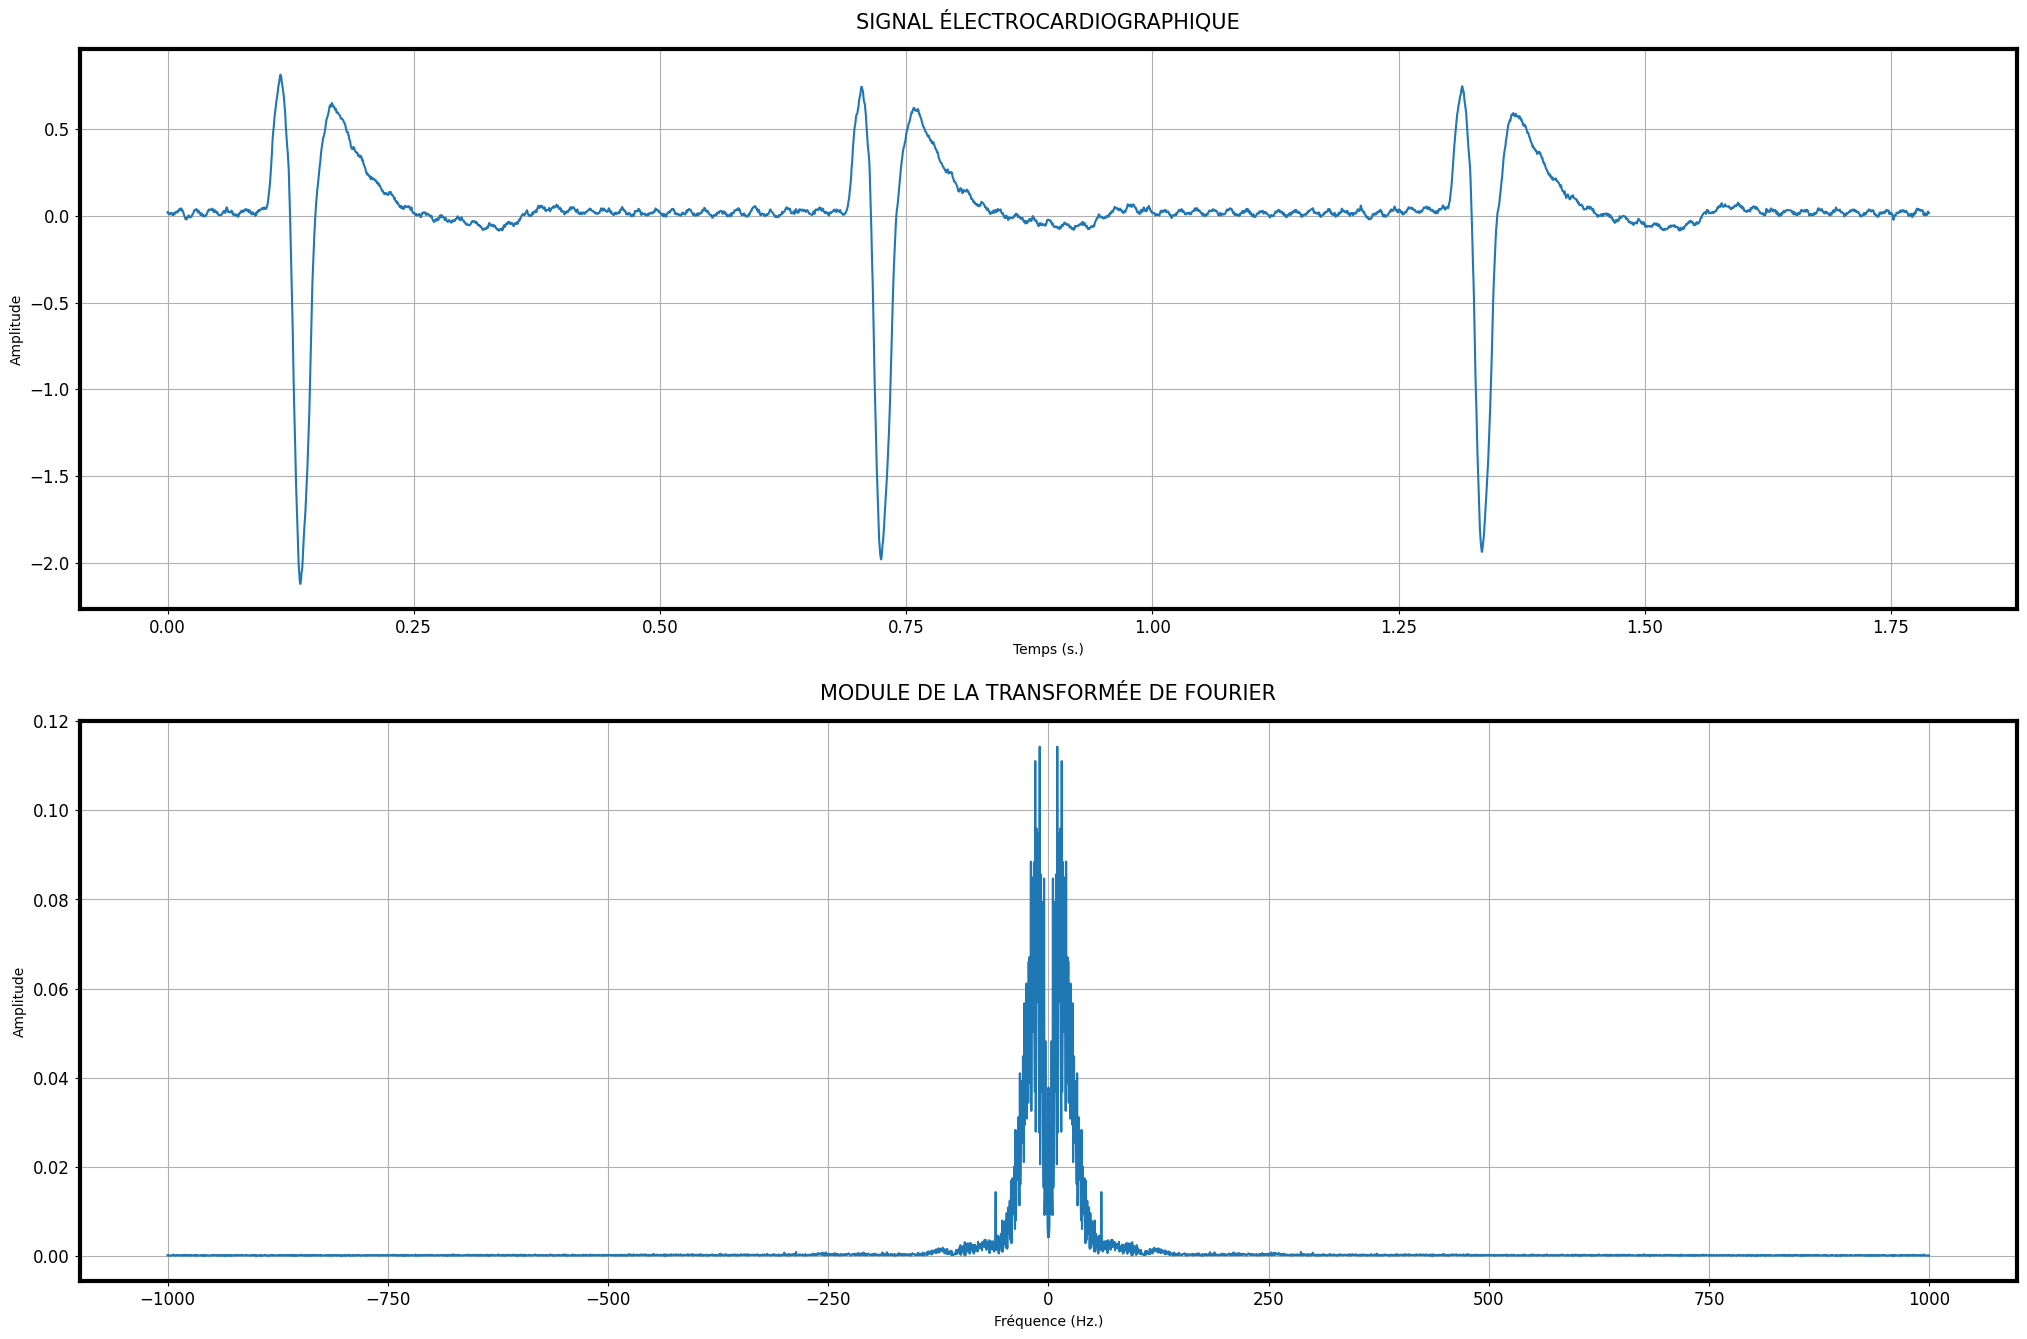

In [5]:
x = ecg['ecg_ref'][0:3578,0]
fe = 2000.0
Te = 1 / fe
N = len(x)
Nx = 4000
t = np.arange(0,N) * Te

plt.subplot(211)
plt.plot(t,x)
plt.grid('on')
plt.xlabel('Temps (s.)')
plt.ylabel('Amplitude')
plt.title('SIGNAL ÉLECTROCARDIOGRAPHIQUE')

X = Te * np.fft.fft(x,n=4000)

#nu = (0:Nx-1)/(Nx*Te);
nu = (np.arange(- Nx / 2,Nx/2 )) / (Nx * Te)

plt.subplot(212)
plt.plot(nu,np.fft.fftshift(np.abs(X)))
plt.grid('on')
plt.xlabel('Fréquence (Hz.)')
plt.ylabel('Amplitude')
plt.title('MODULE DE LA TRANSFORMÉE DE FOURIER')
plt.show()

## Choix de la fréquence d'échantillonage

In [6]:
slider = widgets.IntSlider(min=1, max=150, step=1, description='f échantillons:', readout=True,)
display(slider)

IntSlider(value=1, description='f échantillons:', max=150, min=1)

## Échantillonnage et module de la transformée de Fourier du signal échantillonné

Le signal est échantillonné avec la fréquence choisie aux endroits où se trouvent les lignes rouges. Les lignes roses dans le graphique de la TF du signal correspondent à – Fe/2 et + Fe/2. Ainsi, lorsque que la Fe est réduite, l’intervalle délimité par les 2 lignes diminue également et le nombre de répétition du signal augmente.

In [7]:
def shift(x, shiftsize):
    """
    Décalage d'un vecteur de SHIFTSIZE éléments, avec remplissage des trous par des zéros.
    Si SHIFTSIZE > 0, le décalage se fait vers la droite ou vers le bas.

    Si SHIFTSIZE < 0, le décalage se fait vers la gauche ou vers le haut.
    """
    A = x.shape
    z = np.zeros(np.abs(shiftsize))
    aux = np.concatenate((z,x,z))
    y = np.roll(aux,shiftsize)

    return y[np.abs(shiftsize):np.abs(shiftsize)+A[0]]

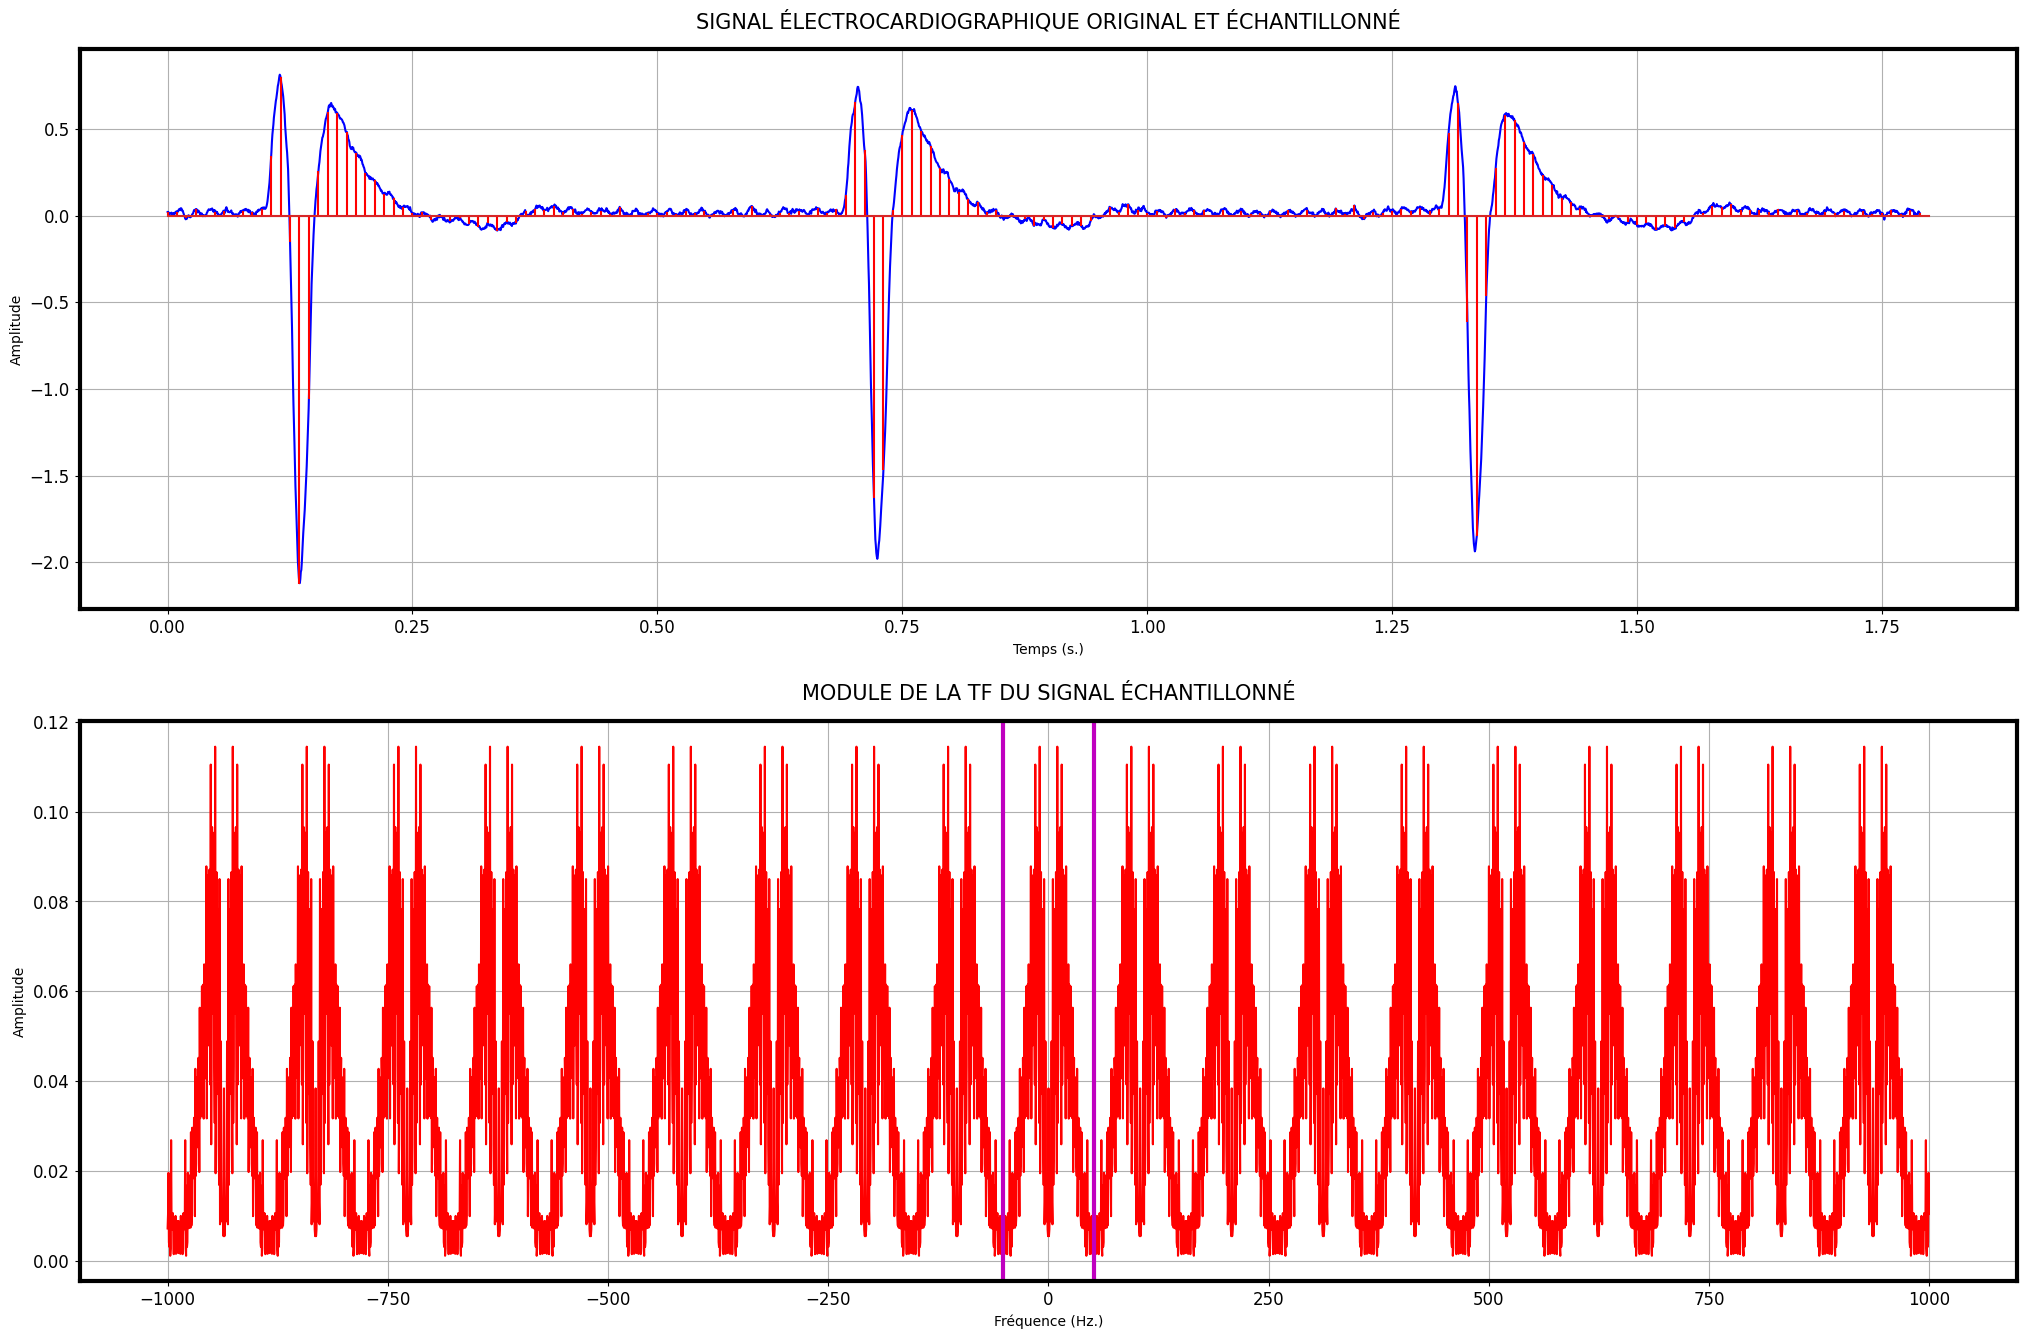

In [8]:
fey = slider.value

# Construction de la TF du signal échantillonné
Ney = int(fey * (Nx * Te))

Y = -np.fft.fftshift(X)

for shiftsize in np.arange(0,Nx+Ney,Ney):
    Y = Y + shift(np.fft.fftshift(X), int(shiftsize))
    Y = Y + shift(np.fft.fftshift(X), -int(shiftsize))

# Construction du signal échantillonné
Ye = Y[int((Nx-Ney)/2):int((Nx+Ney)/2)]
ye = np.real(np.fft.ifft(np.fft.fftshift(Ye))) * fey
te = np.arange(0,(N-1)*Te+1/fey,1/fey)

plt.subplot(211);
plt.plot(t,x,'b')
#plt.stem(te,ye[0:len(te)],'r','none')
plt.stem(te,ye[0:len(te)],'r', markerfmt=" ")

plt.grid('on')
plt.xlabel('Temps (s.)')
plt.ylabel('Amplitude')
plt.title('SIGNAL ÉLECTROCARDIOGRAPHIQUE ORIGINAL ET ÉCHANTILLONNÉ')

plt.subplot(212);
plt.plot(nu,np.abs(Y),'r')
lims=plt.gca().get_ylim()
plt.plot(np.array([- fey / 2,- fey / 2]),lims,'m',linewidth=3)
plt.plot(np.array([fey / 2,fey / 2]),lims,'m',linewidth=3)
plt.ylim(lims)
plt.grid('on')
plt.xlabel('Fréquence (Hz.)')
plt.ylabel('Amplitude')
plt.title('MODULE DE LA TF DU SIGNAL ÉCHANTILLONNÉ')
plt.show()


## Reconstruction du signal

Le signal est ensuite reconstruit à partir de la TF du signal échantillonné. Une période de la TF est bourrée de zéros pour obtenir la même taille que le signal original. Une TF inverse est ensuite appliquée pour obtenir le signal reconstruit. On peut remarquer que plus la Fe est faible, plus le signal reconstruit semble lissé et dépourvu de contenu à haute fréquence. Ceci se reflète dans la TF du signal reconstruit : la TF tombe abruptement à zéro hors de l’intervalle – Fe/2 et + Fe/2.

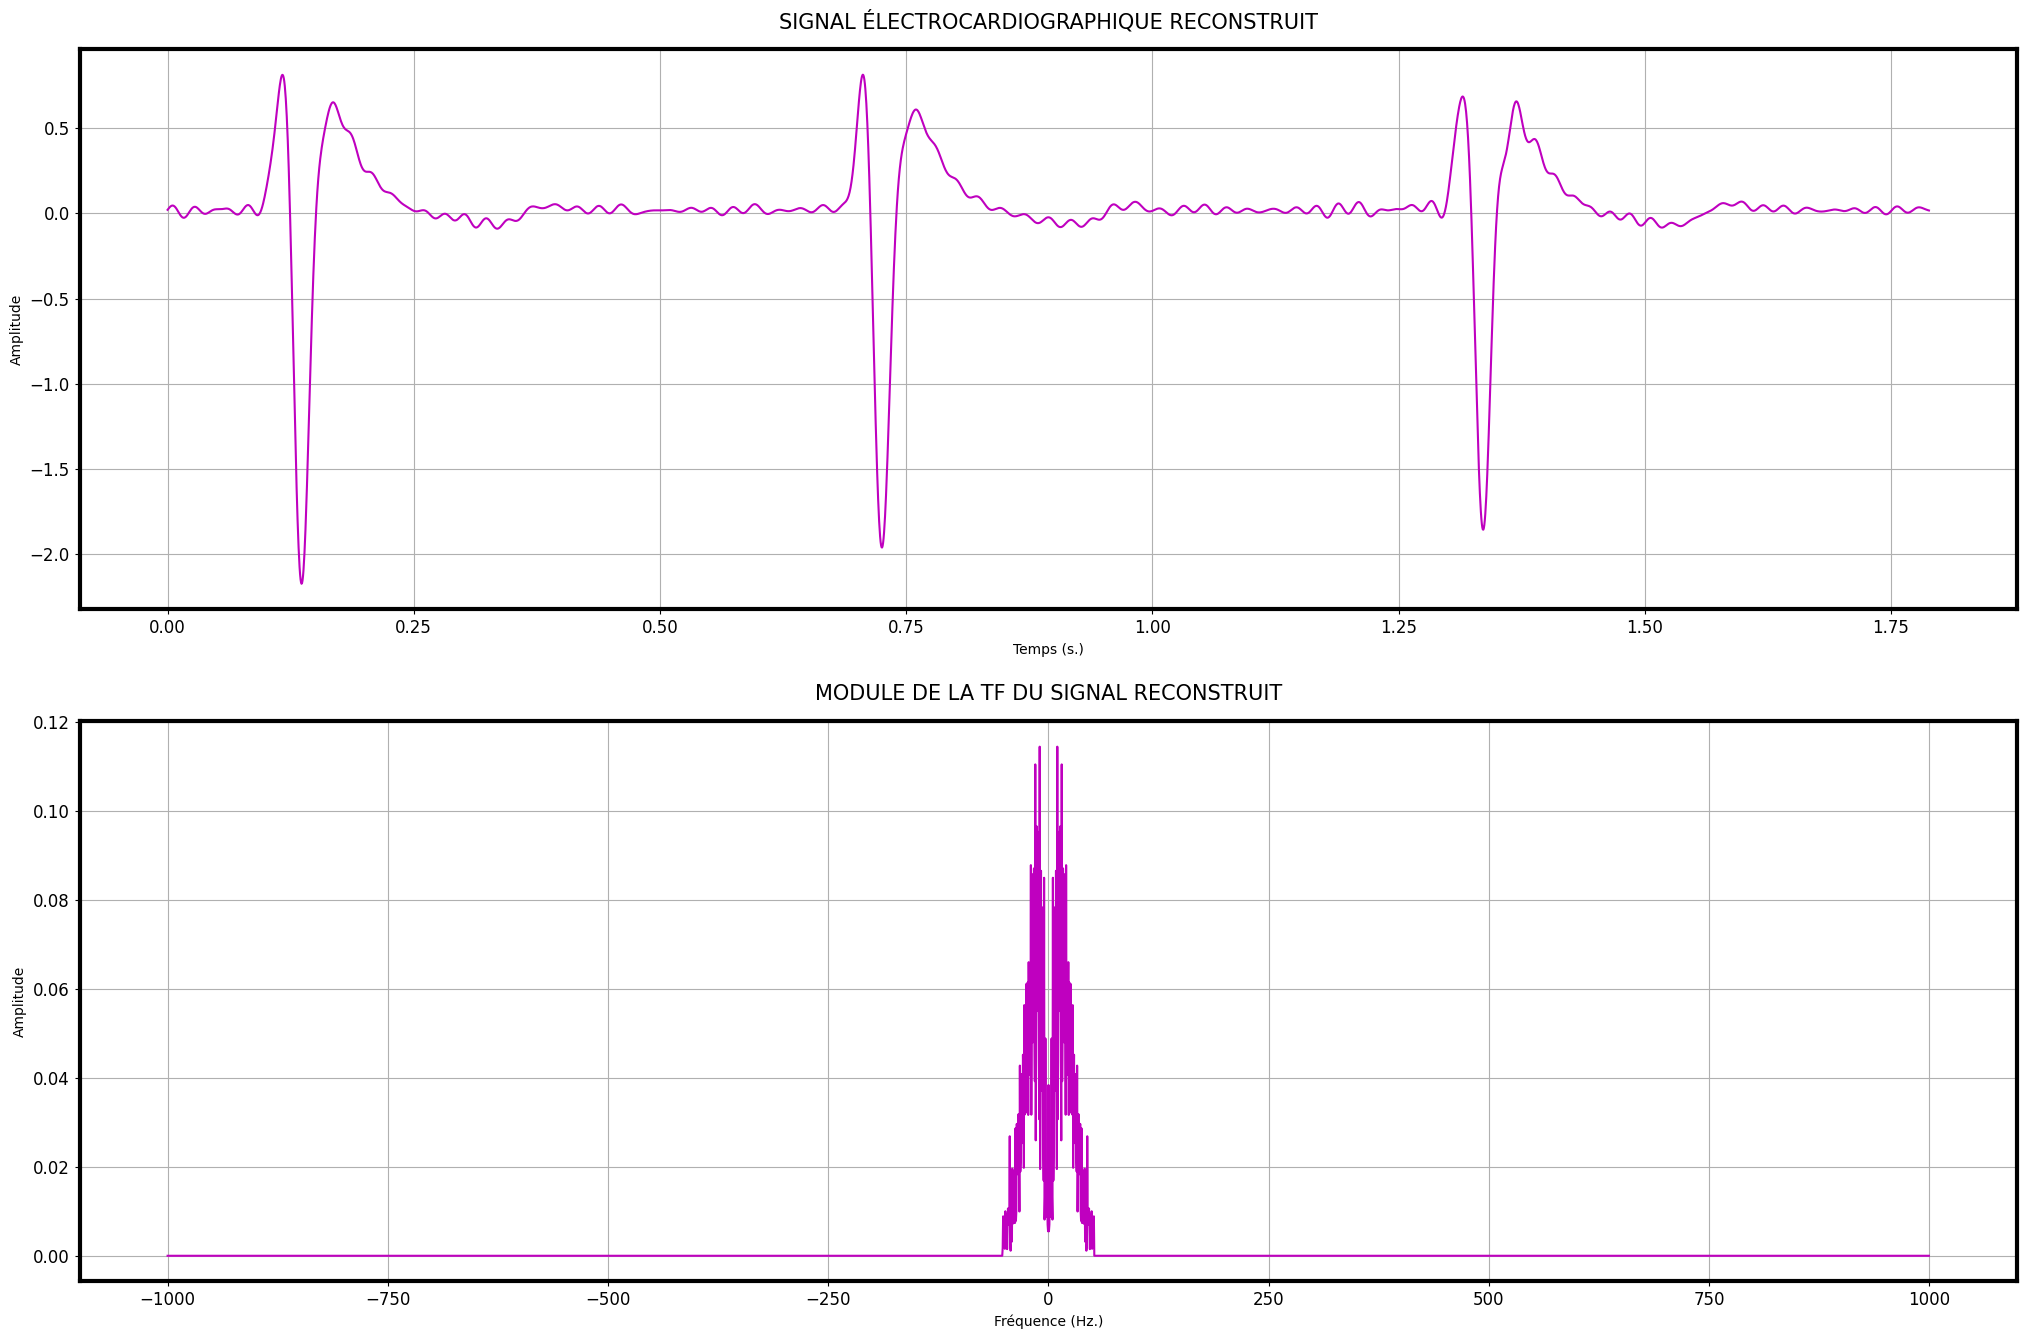

In [9]:
# Reconstruction du signal
Yr = np.zeros(Y.shape[0],dtype='complex128')
Yr[int((Nx-Ney)/2):int((Nx+Ney)/2)] = Ye
yr = np.real(np.fft.ifft(np.fft.fftshift(Yr))) * fe

plt.subplot(211);
plt.plot(t,yr[0:N],'m')
plt.grid('on')
plt.xlabel('Temps (s.)')
plt.ylabel('Amplitude')
plt.title('SIGNAL ÉLECTROCARDIOGRAPHIQUE RECONSTRUIT')

plt.subplot(212);
plt.plot(nu,np.abs(Yr),'m')
plt.grid('on')
plt.xlabel('Fréquence (Hz.)')
plt.ylabel('Amplitude')
plt.title('MODULE DE LA TF DU SIGNAL RECONSTRUIT')
plt.show()

## Comparaison signal original et reconstruit

La différence entre le signal original et le signal reconstruit montre que la reconstruction est de moins en moins fidèle à mesure que Fe diminue. L’amplitude de la différence augmente et on peut voir apparaitre des fréquences de plus en plus basses dans la différence. À noter que l’échelle de l’axe des y change lorsque la Fe est modifiée.

En observant la différence obtenue en soustrayant le module de la TF du signal reconstruit à celui du signal original, on peut voir que le signal reconstruit contient moins de contenu à haute fréquence que le signal original. On remarque aussi que la différence n’est pas nulle dans l’intervalle – Fe/2 et + Fe/2. Par l’effet du repliement, du contenu fréquentiel absent du signal original a été introduit dans le signal reconstruit.


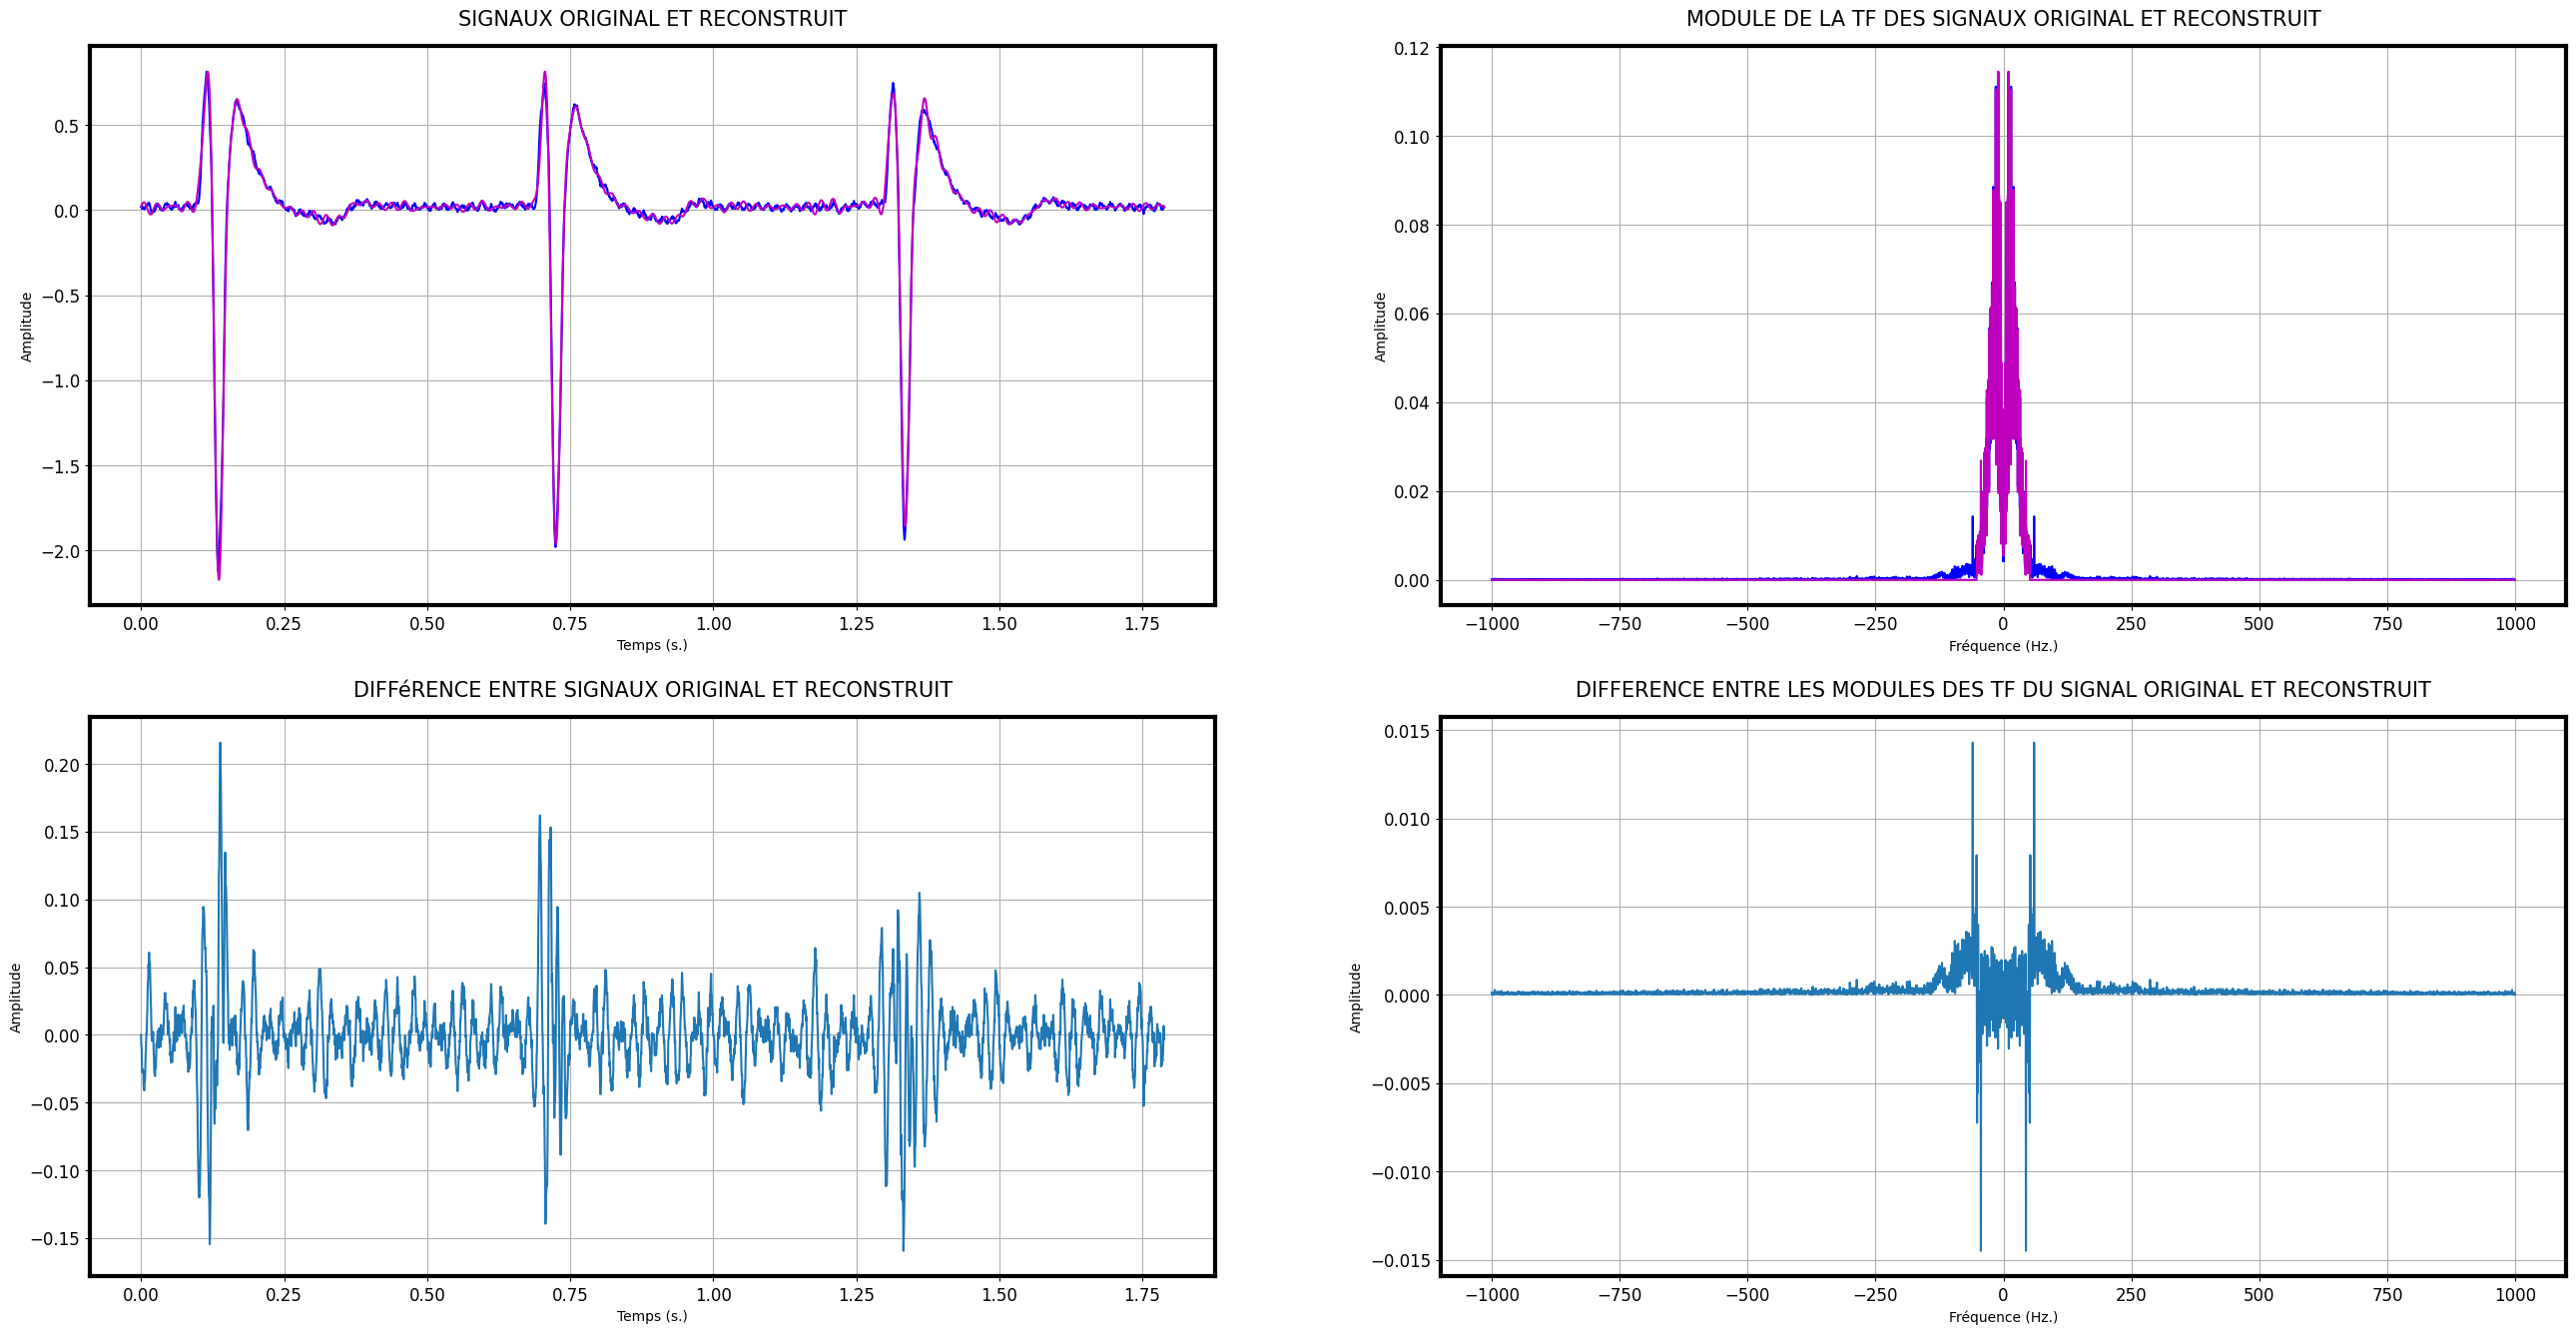

In [10]:
plt.rcParams['figure.figsize'] = (32,16)

plt.subplot(221);
plt.plot(t,x,'b')
plt.plot(t,yr[0:N],'m')
plt.grid('on')
plt.xlabel('Temps (s.)')
plt.ylabel('Amplitude')
plt.title('SIGNAUX ORIGINAL ET RECONSTRUIT')

plt.subplot(222);
plt.plot(nu,np.abs(np.fft.fftshift(X)),'b')
plt.plot(nu,np.abs(Yr),'m')
plt.grid('on')
plt.xlabel('Fréquence (Hz.)')
plt.ylabel('Amplitude')
plt.title('MODULE DE LA TF DES SIGNAUX ORIGINAL ET RECONSTRUIT')

plt.subplot(223);
plt.plot(t,x - yr[0:N])
plt.grid('on')
plt.xlabel('Temps (s.)')
plt.ylabel('Amplitude')
plt.title('DIFFéRENCE ENTRE SIGNAUX ORIGINAL ET RECONSTRUIT')

plt.subplot(224);
plt.plot(nu, np.abs(np.fft.fftshift(X))- np.abs(Yr))
plt.grid('on')
plt.xlabel('Fréquence (Hz.)')
plt.ylabel('Amplitude')
plt.title('DIFFERENCE ENTRE LES MODULES DES TF DU SIGNAL ORIGINAL ET RECONSTRUIT')

plt.show()